In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.enums import STATE_TO_CENSUS_REGION

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]

matplotlib.rcParams["figure.figsize"] = (10, 4)
matplotlib.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

# Read data from PUDL DB and create some features 

In [5]:
%%time
sql_select = """
    -- SQLite
    SELECT
        frc.plant_id_eia,
        frc.report_date,
        frc.contract_type_code,
        frc.contract_expiration_date,
        frc.energy_source_code,
        frc.supplier_name, -- Messy
        frc.fuel_received_units,
        frc.fuel_mmbtu_per_unit,
        frc.sulfur_content_pct,
        frc.ash_content_pct,
        frc.mercury_content_ppm,
        frc.moisture_content_pct,
        frc.chlorine_content_ppm,
        frc.fuel_cost_per_mmbtu,
        frc.primary_transportation_mode_code,
        frc.secondary_transportation_mode_code,
        frc.natural_gas_transport_code,
        frc.natural_gas_delivery_contract_type_code,

        mine.mine_name, -- Messy string
        mine.mine_type_code,
        mine.county_id_fips as mine_county_id_fips,
        mine.state as mine_state,
        mine.mine_id_msha,

        entity.iso_rto_code,
        entity.latitude,
        entity.longitude,
        entity.state,
        entity.county, -- Add county FIPS code
        entity.sector_name_eia,
        
        esc.fuel_group_eiaepm

    FROM fuel_receipts_costs_eia923 as frc
    LEFT JOIN coalmine_eia923 as mine
        USING (mine_id_pudl)
    LEFT JOIN plants_entity_eia as entity
        USING (plant_id_eia)
    LEFT JOIN energy_sources_eia as esc
           ON esc.code = frc.energy_source_code
    ;
"""
logger.info("Query data from the PUDL DB.")
frc_orig = (
    pd.read_sql(sql_select, pudl_engine)
    .pipe(apply_pudl_dtypes, group="eia")
    .pipe(pudl.helpers.add_fips_ids)
    .assign(
        # Remove 225 totally ridiculous outliers that skew the results
        fuel_cost_per_mmbtu=lambda x: np.where(((x.fuel_cost_per_mmbtu < 0.001) | (x.fuel_cost_per_mmbtu > 1000)), np.nan, x.fuel_cost_per_mmbtu),
        # Numerical representation of elapsed time
        elapsed_days=lambda x: (x.report_date - x.report_date.min()).dt.days,
        # Time until current contract expires
        remaining_contract_days=lambda x: (x.contract_expiration_date - x.report_date).dt.days,
        # Categorical months, to capture cyclical seasonal variability
        report_month=lambda x: x.report_date.dt.month,
        # Larger geographic area more likely to have lots of records
        census_region=lambda x: x.state.map(STATE_TO_CENSUS_REGION),
        # Need the total MMBTU for weighting the importance of the record
        # May also be predictive -- small deliveries seem more likely to be expensive
        fuel_received_mmbtu=lambda x: x.fuel_received_units * x.fuel_mmbtu_per_unit,
        mine_plant_same_state=lambda x: (x.state == x.mine_state).fillna(False),
        mine_plant_same_county=lambda x: (x.county_id_fips == x.mine_county_id_fips).fillna(False),
    )
    .convert_dtypes(convert_floating=False, convert_integer=False)
    .astype({
        "mine_id_msha": float,
        "plant_id_eia": int,
    })
)
# The HistGBR model and OrdinalEncoder are supposedly fine with NA values but...
string_cols = frc_orig.select_dtypes("string").columns
frc_orig.loc[:, string_cols] = frc_orig[string_cols].fillna("NULL")

# There are too many FIPS codes to treat them like categories
bad_categories = ["county_id_fips", "mine_county_id_fips"]
category_cols = {col: "category" for col in string_cols if col not in bad_categories}

frc_orig = frc_orig.astype(category_cols)

# Preserve the original so we can compare later
frc = frc_orig.copy()

frc.info()

Query data from the PUDL DB.
Assigned state FIPS codes for 98.16% of records.
Assigned county FIPS codes for 94.75% of records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571400 entries, 0 to 571399
Data columns (total 39 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   plant_id_eia                             571400 non-null  int64         
 1   report_date                              571400 non-null  datetime64[ns]
 2   contract_type_code                       571400 non-null  category      
 3   contract_expiration_date                 248824 non-null  datetime64[ns]
 4   energy_source_code                       571400 non-null  category      
 5   supplier_name                            571400 non-null  category      
 6   fuel_received_units                      571400 non-null  float64       
 7   fuel_mmbtu_per_unit                      571400 non-nu

# Select features to use

In [6]:
keep_cols = [
# Categorical
    "energy_source_code",
    "census_region",
    "contract_type_code",
    "primary_transportation_mode_code",
    "secondary_transportation_mode_code",
    "natural_gas_delivery_contract_type_code",
    "natural_gas_transport_code",
    "mine_type_code",
    "mine_county_id_fips",
    "mine_state",
    "iso_rto_code",
    "sector_name_eia",
    "county_id_fips",
    "mine_plant_same_state",  # bool
    "mine_plant_same_county", # bool
    "fuel_group_eiaepm",
    "state",
    
# Numerical
    "mine_id_msha",
    "latitude",
    "longitude",
    "sulfur_content_pct",
    "ash_content_pct",
    "moisture_content_pct",
    "mercury_content_ppm",
    "chlorine_content_ppm",
    "remaining_contract_days",
    "plant_id_eia", 
    "report_month",
    "elapsed_days",
    "fuel_cost_per_mmbtu",
    "fuel_received_mmbtu",
#   "fuel_mmbtu_per_unit",
#   "fuel_received_units",
]

# Records where we're missing the target value:
frc_to_predict = frc.loc[frc.fuel_cost_per_mmbtu.isna(), keep_cols]

# Records where we have the target value:
frc_train_test = frc.loc[frc.fuel_cost_per_mmbtu.notna(), keep_cols]

# Relative importance of each of the records:
sample_weight=frc_train_test["fuel_received_mmbtu"]

# The target we're trying to predict:
frc_target = frc_train_test["fuel_cost_per_mmbtu"]

# The data we're going to use to predict:
frc_data = frc_train_test.drop(columns=["fuel_cost_per_mmbtu", "fuel_received_mmbtu"])

In [7]:
frc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381214 entries, 0 to 571399
Data columns (total 29 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   energy_source_code                       381214 non-null  category
 1   census_region                            381214 non-null  category
 2   contract_type_code                       381214 non-null  category
 3   primary_transportation_mode_code         381214 non-null  category
 4   secondary_transportation_mode_code       381214 non-null  category
 5   natural_gas_delivery_contract_type_code  381214 non-null  category
 6   natural_gas_transport_code               381214 non-null  category
 7   mine_type_code                           381214 non-null  category
 8   mine_county_id_fips                      381214 non-null  string  
 9   mine_state                               381214 non-null  category
 10  iso_rto_code        

# Build a Pipeline

In [13]:
# Identify which columns should be treated as categorical features:
cat_cols_idx = frc_data.columns.get_indexer(frc_data.select_dtypes("category").columns)

ord_enc = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include=["category", "string"]),
    ),
    remainder="passthrough",
)

pipe = Pipeline([
    ("ord_enc", ord_enc),
    ("hist_gbr", HistGradientBoostingRegressor(loss="absolute_error", categorical_features=cat_cols_idx)),
])

## Grid Search Cross Validation

In [14]:
%%time
# Split based on Plant ID to avoid plant information leaking between test / training
gkf = GroupKFold(n_splits=5)
gkf_split = gkf.split(frc_data, groups=frc_data["plant_id_eia"])
param_grid = {
    "hist_gbr__max_depth": [5],
    "hist_gbr__max_leaf_nodes": [31],
    "hist_gbr__learning_rate": [0.3],
#    "hist_gbr__max_depth": [3, 5, 7],
#    "hist_gbr__max_leaf_nodes": [7, 15, 31],
#    "hist_gbr__learning_rate": [0.1, 0.3, 0.9],
}

# Define hyperparameter space to search:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=gkf_split,
    scoring='neg_median_absolute_error',
    n_jobs=-1,
)

# Train up all the models and store the results.
# Weight samples by `sample_weight` during training.
result = grid.fit(
    X=frc_data,
    y=frc_target,
    hist_gbr__sample_weight=sample_weight,
)

CPU times: user 30.7 s, sys: 595 ms, total: 31.3 s
Wall time: 57.4 s


In [15]:
old_best_params = {
    'hist_gbr__learning_rate': 0.3,
    'hist_gbr__max_depth': 7,
    'hist_gbr__max_leaf_nodes': 31,
}

new_best_params = {
    'hist_gbr__learning_rate': 0.3,
    'hist_gbr__max_depth': 5,
    'hist_gbr__max_leaf_nodes': 31,
}

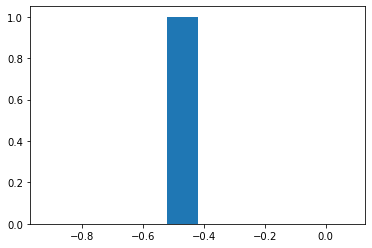

In [16]:
plt.hist(result.cv_results_["mean_test_score"]);

## Use the best estimator to predict missing fuel prices

In [17]:
%%time
# Take the estimator with the winning hyperparameters
est = grid.best_estimator_

# Fit it using all of the available training data
_ = est.fit(
    X=frc_data,
    y=frc_target,
    hist_gbr__sample_weight=sample_weight,
)

# Use it to predict the missing fuel prices
predicted_fuel_costs = est.predict(X=frc_to_predict)

# Add the predicted values back to the rest of the data for exploration
frc_predicted = (
    frc_to_predict.copy()
    .drop(columns=["fuel_cost_per_mmbtu"])
    .assign(fuel_cost_per_mmbtu=predicted_fuel_costs)
)

frc_predicted

CPU times: user 47.3 s, sys: 411 ms, total: 47.7 s
Wall time: 23.2 s


,energy_source_code,census_region,contract_type_code,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_delivery_contract_type_code,natural_gas_transport_code,mine_type_code,mine_county_id_fips,mine_state,iso_rto_code,sector_name_eia,county_id_fips,mine_plant_same_state,mine_plant_same_county,fuel_group_eiaepm,state,mine_id_msha,latitude,longitude,sulfur_content_pct,ash_content_pct,moisture_content_pct,mercury_content_ppm,chlorine_content_ppm,remaining_contract_days,plant_id_eia,report_month,elapsed_days,fuel_received_mmbtu,fuel_cost_per_mmbtu
154,NG,PCC,S,NULL,NULL,NULL,firm,NULL,NULL,NULL,CAISO,IPP Non-CHP,06013,False,False,natural_gas,CA,NaN,38.019200,-121.764200,0.0,0.0,NaN,NaN,NaN,NaN,228,1,0,185.220,7.827359
157,NG,PCC,S,NULL,NULL,NULL,firm,NULL,NULL,NULL,CAISO,NULL,06079,False,False,natural_gas,CA,NaN,35.372167,-120.856562,0.0,0.0,NaN,NaN,NaN,0.0,259,1,0,121225.980,8.539389
158,NG,PCC,S,NULL,NULL,NULL,firm,NULL,NULL,NULL,CAISO,IPP Non-CHP,06053,False,False,natural_gas,CA,NaN,36.804837,-121.782241,0.0,0.0,NaN,NaN,NaN,NaN,260,1,0,1186374.240,8.141905
159,NG,PCC,S,NULL,NULL,NULL,firm,NULL,NULL,NULL,CAISO,IPP Non-CHP,06053,False,False,natural_gas,CA,NaN,36.804837,-121.782241,0.0,0.0,NaN,NaN,NaN,0.0,260,1,0,3609207.780,8.021999
160,NG,PCC,S,NULL,NULL,NULL,firm,NULL,NULL,NULL,CAISO,IPP Non-CHP,06013,False,False,natural_gas,CA,NaN,38.039168,-121.894469,0.0,0.0,NaN,NaN,NaN,NaN,271,1,0,64.638,7.827359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571386,NG,NEW,S,PL,NULL,firm,firm,NULL,NULL,NULL,NULL,IPP Non-CHP,25009,False,False,natural_gas,MA,NaN,42.525486,-70.878240,0.0,0.0,NaN,0.0,NaN,NaN,60903,12,4718,1322980.800,4.095054
571394,NG,MAT,C,PL,NULL,firm,firm,NULL,NULL,NULL,NULL,IPP Non-CHP,42073,False,False,natural_gas,PA,NaN,40.994444,-80.430000,0.0,0.0,NaN,0.0,NaN,881.0,61028,12,4718,4343603.000,3.056154
571395,NG,MAT,C,PL,NULL,firm,firm,NULL,NULL,NULL,NULL,IPP Non-CHP,42011,False,False,natural_gas,PA,NaN,40.268522,-75.799670,0.0,0.0,NaN,0.0,NaN,6574.0,61035,12,4718,1907239.180,3.770215
571397,NG,PCC,C,PL,NULL,firm,firm,NULL,NULL,NULL,NULL,IPP Non-CHP,06037,False,False,natural_gas,CA,NaN,33.767229,-118.100194,0.0,0.0,NaN,0.0,NaN,0.0,62115,12,4718,804976.260,3.483677


## Visualize the predicted prices by fuel group
* Time series by (fuel, state):
  * Predicted vs Reported for test/train
  * Time series where gaps are filled, highlighting original / filled values
* Distribution of Predicted vs. Reported values for test/train data

Predicted Fuel Prices


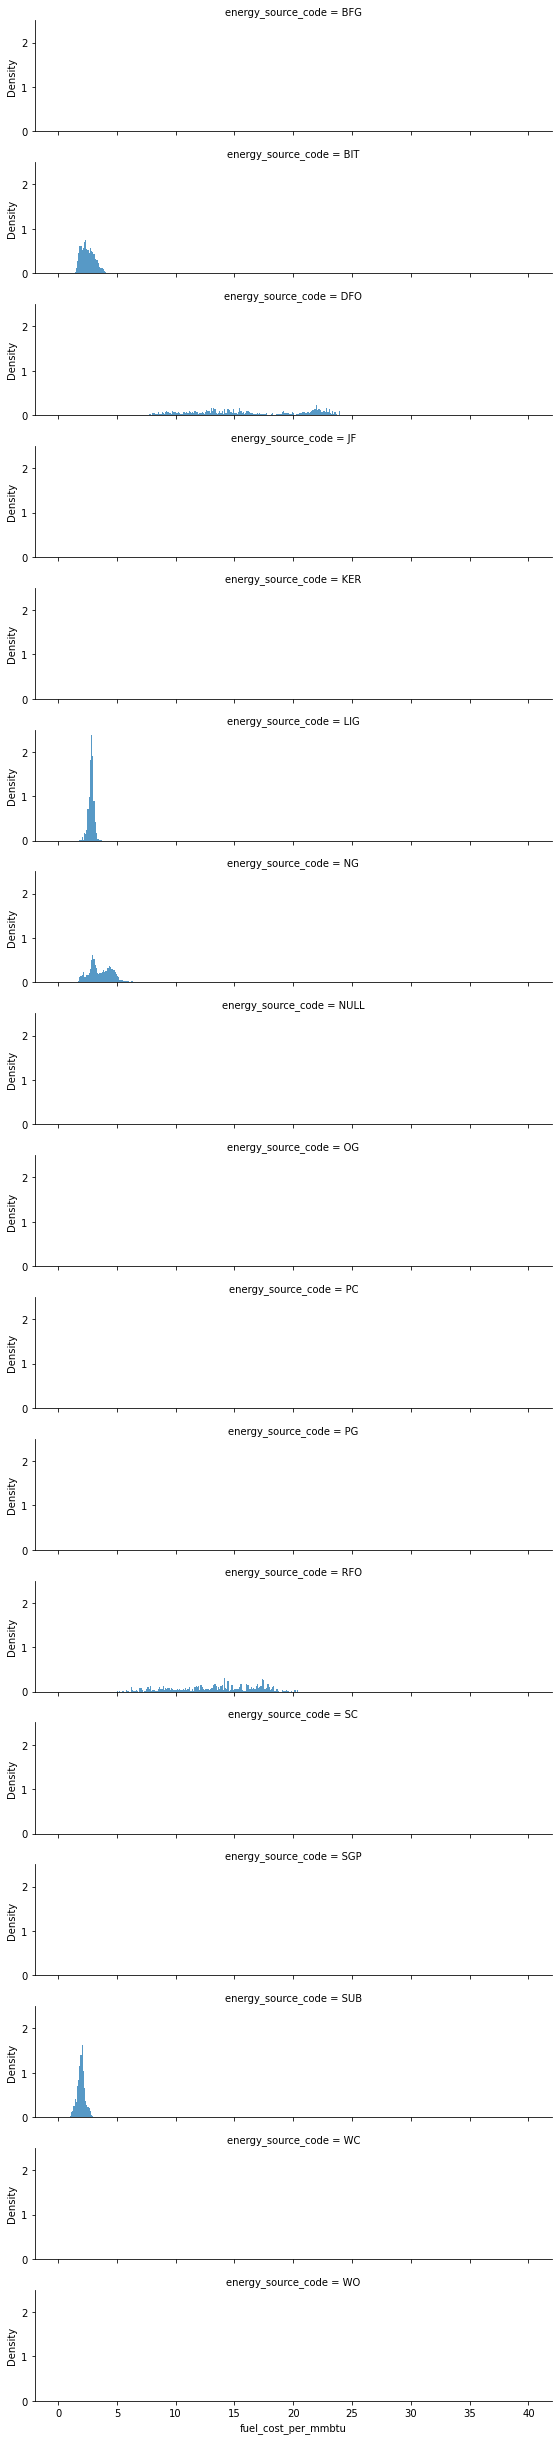

Observed Fuel Prices


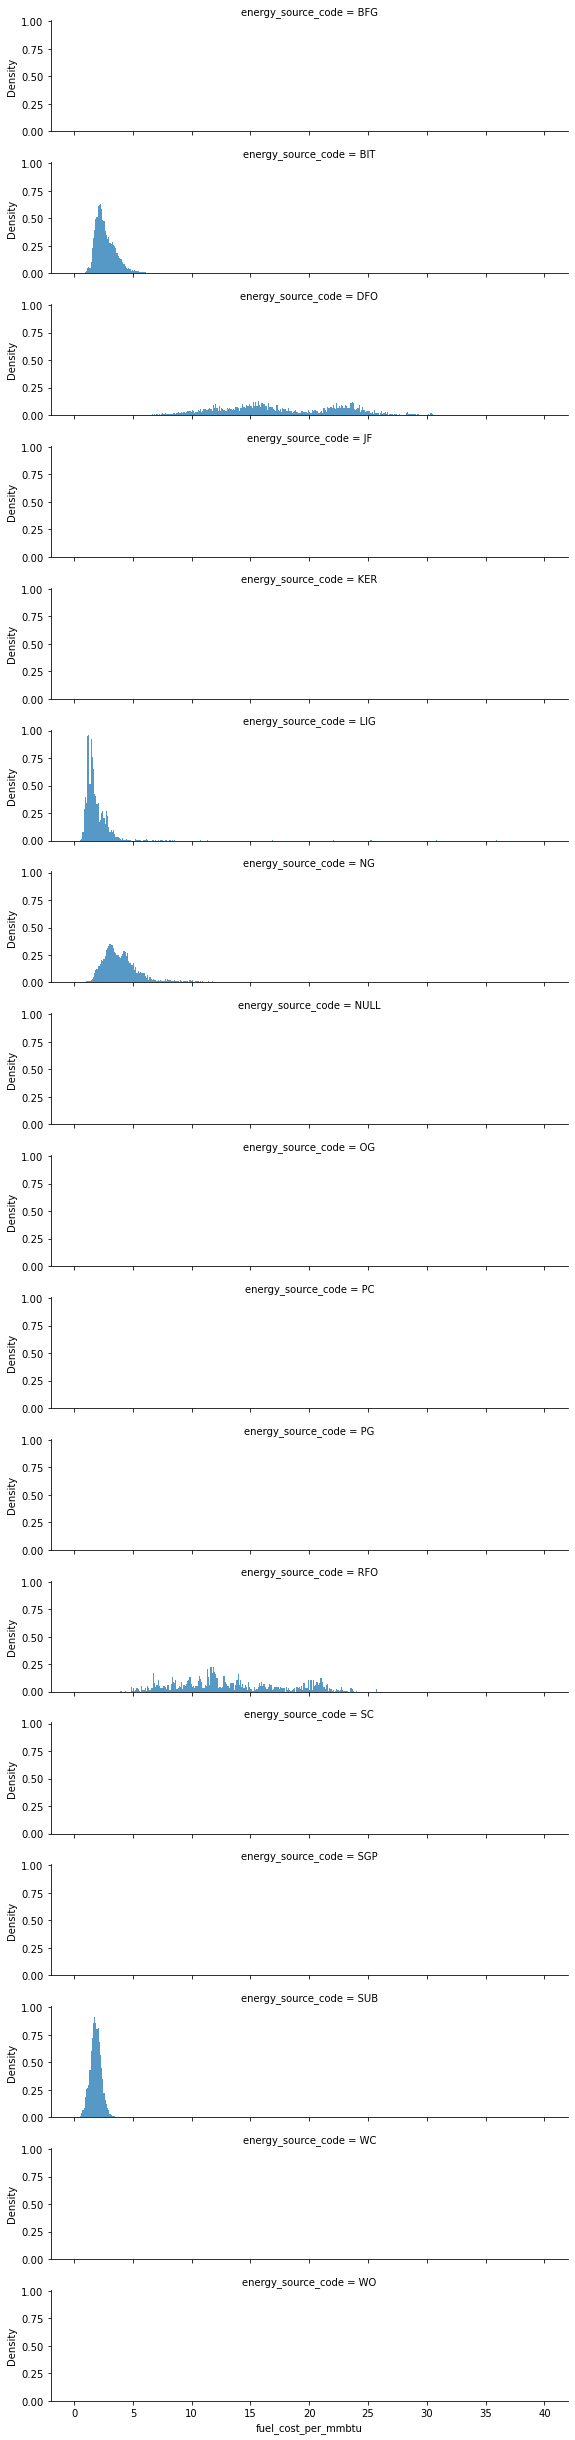

In [23]:
mfcs = {
    "energy_source_code": ["BIT", "SUB", "LIG", "NG", "DFO", "RFO"],
    "fuel_group_eiaepm": ["coal", "petroleum", "natural_gas"],
}
mfc = "energy_source_code"
# mfc = "fuel_group_eiaepm"

logger.info("Predicted Fuel Prices")
sns.displot(
    data=frc_predicted[frc_predicted[mfc].isin(mfcs[mfc])],
    x="fuel_cost_per_mmbtu",
    row=mfc,
    bins=400,
    weights=frc_predicted[frc_predicted[mfc].isin(mfcs[mfc])]["fuel_received_mmbtu"],
    binrange=(0,40),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    common_norm=False,
)
plt.show();

logger.info("Observed Fuel Prices")
sns.displot(
    data=frc_train_test[frc_train_test[mfc].isin(mfcs[mfc])],
    x="fuel_cost_per_mmbtu",
    row=mfc,
    bins=400,
    weights=frc_train_test[frc_train_test[mfc].isin(mfcs[mfc])]["fuel_received_mmbtu"],
    binrange=(0,40),
    height=2,
    aspect=4,
    linewidth=0,
    stat="density",
    common_norm=False,
)
plt.show();